## Introduction

### Definitions

##### Global Blocktree
A global tree maintained during the simulation used to determine certain statistics

##### Node Tree
A Node has a tree structure consisting of tree blocks just like in the Longest Chain Protocol.

##### Main Chain
On a tree structure, the main chain is defined in this protocol as the Longest Chain from the Genesis block to a leaf block.

##### Node Pool
A node also has a pool structure consisting of pool blocks. 

##### Tree Block
A block on the global blocktree or in a node's local tree.

##### Pool Block
A block in a node's local pool. The block may or may not be referenced by the next tree block proposed by the node.

##### Finalized
A block is considered finalized in two cases:

1) If in a tree block - if the block is `k` blocks deep on the main chain
2) If in a pool block - if the pool block is referenced by a tree block that is finalized

A transaction is considered finalized if it is in a finalized block

## Simulation Description

We measure multiple metrics to understand a transactions behavior during the simulation. 

#### Throughput
How many of the transactions generated actually get finalized in the simulation? 

#### Unique Throughput
How many of the unique transactions generated actually get finalized in the simulation? 

#### Pool Block Arrival Latency
How long does it take for a transaction to make it into a pool block?

#### Pool Block Reference Latency
How long does it take for a transaction to make it into a pool block and get referenced?

#### Main Chain Arrival Latency
How long does it take for a transaction to make it onto the main chain (for both pool blocks and tree blocks)?

#### Finalization Latency
How long does it take for a transaction to be finalized once it arrives on the main chain?


### Experimental Parameters

In [1]:
import numpy as np, json
%matplotlib inline
'''
num_tests = 2
n_trials = 1
tree_proposal_rates = np.linspace(0.1, 0.1, num_tests)
pool_proposal_rates = np.linspace(4, 5, num_tests)
'''
# Use these to overwrite and run real tests
num_tests = 5
n_trials = 3
tree_proposal_rates = np.linspace(0.1, 0.1, num_tests)
pool_proposal_rates = np.linspace(0.1, 3, num_tests)

# Create experimental parameters and write to JSON file

params = {'Block tree proposal rate parameter': 0,
 'Block pool proposal rate parameter': 0,
 'Transaction rate parameter': 0,
 'Block size (txs)': 30,
 'Duration (sec)': 0,
 'Fork choice rule': 'longest-chain-with-pool',
 'Transaction scheduling rule': 'FIFO',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 10,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson',
 'Logging enabled': True}

### Run experiments

In [2]:
import os, shutil, pprint, glob, csv, time

pp = pprint.PrettyPrinter()
os.system('touch longest_chain_with_pool.json')
dirname = f'longest_chain_with_pool_' + str(int(time.time()))
os.system(f'mkdir {dirname}')
os.chdir('..')
import metrics

throughputs = {}
unique_throughputs = {}
pool_block_arrival_latencies = {}
pool_block_ref_latencies = {}
main_chain_arrival_latencies = {}
finalization_latencies = {}
emptiness = {}

for i in range(0, num_tests):
    tree_rate = tree_proposal_rates[i]
    pool_rate = pool_proposal_rates[i]
    params['Block tree proposal rate parameter'] = tree_rate
    params['Block pool proposal rate parameter'] = pool_rate
    params['Transaction rate parameter'] = 0.9*(tree_rate+pool_rate)*int(params['Block size (txs)'])
    params['Duration (sec)'] = 400
    d = {}
    d['setting-name'] = f'longest-chain-with-pool'
    d[f'longest-chain-with-pool'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('results/longest_chain_with_pool.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[(tree_rate, pool_rate)] = []
    unique_throughputs[(tree_rate, pool_rate)] = []
    pool_block_arrival_latencies[(tree_rate, pool_rate)] = []
    pool_block_ref_latencies[(tree_rate, pool_rate)] = []
    main_chain_arrival_latencies[(tree_rate, pool_rate)] = []
    finalization_latencies[(tree_rate, pool_rate)] = []
    emptiness[(tree_rate, pool_rate)] = []
    for trial in range(0, n_trials):
        os.system('python3.7 main.py -f results/longest_chain_with_pool.json')
        throughput, unique_throughput = metrics.compute_throughputs(filename='results/longest_chain_with_pool.json')
        
        throughputs[(tree_rate, pool_rate)].append(throughput)
        unique_throughputs[(tree_rate, pool_rate)].append(unique_throughput)
        
        avg_pool_block_arr_latency, avg_pool_block_ref_latency, avg_main_chain_arrival_latency, avg_finalization_latency = metrics.compute_latency()
        
        pool_block_arrival_latencies[(tree_rate, pool_rate)].append(avg_pool_block_arr_latency)
        pool_block_ref_latencies[(tree_rate, pool_rate)].append(avg_pool_block_ref_latency)
        main_chain_arrival_latencies[(tree_rate, pool_rate)].append(avg_main_chain_arrival_latency)
        finalization_latencies[(tree_rate, pool_rate)].append(avg_finalization_latency)
        
        _emptiness = metrics.compute_emptiness()
        emptiness[(tree_rate, pool_rate)].append(_emptiness)
        
        nested_dirname = f'logs_{tree_rate}_{pool_rate}'
        os.system(f'mkdir results/{dirname}/{nested_dirname}')
        os.system(f'cp logs/* results/{dirname}/{nested_dirname}/')
    
os.chdir('results/')
os.remove('longest_chain_with_pool.json')
print('Throughputs:\n', throughputs)
print('Unique Throughputs:\n', unique_throughputs)
print('Pool Block Arrival Latencies:\n', pool_block_arrival_latencies)
print('Pool Block Reference Latencies:\n', pool_block_ref_latencies)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Finalization Latencies:\n', finalization_latencies)
print('Emptiness:\n', emptiness)

Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.1,
                             'Block size (txs)': 30,
                             'Block tree proposal rate parameter': 0.1,
                             'Duration (sec)': 400,
                             'Fork choice rule': 'longest-chain-with-pool',
                             'Logging enabled': True,
                             'Network model': 'Decker-Wattenhorf',
                             'Number of adversaries': 1,
                             'Number of nodes': 10,
                             'Probability of error in transaction confirmation': 0.1,
                             'Transaction dataset': 'poisson',
                             'Transaction rate parameter': 5.4,
                             'Transaction scheduling rule': 'FIFO'},
 'setting-name': 'longest-chain-with-pool'}
Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.825,
                     

### Compute Averages

Average throughput is the number of finalized transactions divided by the duration of the experiment.

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was generated.

Average pool block latency is the time for a transaction to be added to a pool block AND referenced by a tree block.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [3]:
def compute_avg_std_dev(d):
    avgs = {}
    std_devs = {}
    for rate in d:
        if len(d[rate])!=0:
            avgs[rate] = sum(d[rate])/len(d[rate])
            std_devs[rate] = np.std(d[rate])
            
    return avgs, std_devs

print(throughputs)
avg_throughputs_d, throughput_sd = compute_avg_std_dev(throughputs)
'''
avg_uniq_throughputs_d, uniq_throughput_sd = compute_avg_std_dev(unique_throughputs)
avg_pool_block_arr_lat_d, pool_block_arr_sd = compute_avg_std_dev(pool_block_arrival_latencies)
avg_pool_block_ref_lat_d, pool_block_ref_sd = compute_avg_std_dev(pool_block_ref_latencies)
avg_mca_lat_d, mca_lat_sd  = compute_avg_std_dev(main_chain_arrival_latencies)
avg_fin_lat_d, fin_lat_sd  = compute_avg_std_dev(finalization_latencies)
avg_emp_d, emp_sd = compute_avg_std_dev(emptiness)
'''
print('avg_throughputs_d:\n', avg_throughputs_d)
'''
print('avg_uniq_throughputs_d:\n', avg_uniq_throughputs_d)
print('avg_pool_block_arr_lat_d:\n', avg_pool_block_arr_lat_d)
print('avg_pool_block_ref_lat_d:\n', avg_pool_block_ref_lat_d)
print('avg_mca_lat_d:\n', avg_mca_lat_d)
print('avg_fin_lat_d:\n', avg_fin_lat_d)
print('avg_emp_d:\n', avg_emp_d)
'''

{(0.1, 0.1): [2.1625, 3.3375, 2.095], (0.1, 0.825): [22.74, 21.185, 21.3375], (0.1, 1.55): [42.4325, 43.195, 41.695], (0.1, 2.275): [61.6975, 61.485, 58.2175], (0.1, 3.0): [77.26, 68.19, 79.0925]}
avg_throughputs_d:
 {(0.1, 0.1): 2.5316666666666667, (0.1, 0.825): 21.754166666666663, (0.1, 1.55): 42.44083333333333, (0.1, 2.275): 60.46666666666667, (0.1, 3.0): 74.8475}


"\nprint('avg_uniq_throughputs_d:\n', avg_uniq_throughputs_d)\nprint('avg_pool_block_arr_lat_d:\n', avg_pool_block_arr_lat_d)\nprint('avg_pool_block_ref_lat_d:\n', avg_pool_block_ref_lat_d)\nprint('avg_mca_lat_d:\n', avg_mca_lat_d)\nprint('avg_fin_lat_d:\n', avg_fin_lat_d)\nprint('avg_emp_d:\n', avg_emp_d)\n"

### Extract Finalization Depth and Delta for Blocks

In [4]:
import csv
print(os.getcwd())
if os.path.isfile('../logs/stats.csv'):
    print('here')
    with open('../logs/stats.csv', newline='') as csvfile:
        print('here')
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            print(row)
            if row[0]=='Finalization depth':
                k = int(row[1])
            elif row[0]=='Average network latency for blocks (sec)':
                delta_blocks = float(row[1])
            elif row[0]=='Average network latency for txs (sec)':
                delta_txs = float(row[1])
                
delta = delta_blocks+delta_txs                
f_tree = tree_proposal_rates
f_pool = pool_proposal_rates
x = pool_proposal_rates

avg_throughputs = np.array(list(avg_throughputs_d.values()))
'''
avg_uniq_throughputs = np.array(list(avg_uniq_throughputs_d.values()))
avg_pool_block_arr_lat = np.array(list(avg_pool_block_arr_lat_d.values()))
avg_pool_block_ref_lat = np.array(list(avg_pool_block_ref_lat_d.values()))

avg_mca_lat = np.array(list(avg_mca_lat_d.values()))
avg_fin_lat = np.array(list(avg_fin_lat_d.values()))
avg_emp = np.array(list(avg_emp_d.values()))
print(avg_throughputs, avg_uniq_throughputs)
'''
exp_throughput = 0.9*(f_tree+f_pool)*params['Block size (txs)']
'''
exp_uniq_throughput_avg_throughput = avg_throughputs/(1+(f_tree+f_pool)*delta)
exp_uniq_throughput_exp_throughput = exp_throughput/(1+(f_tree+f_pool)*delta)
'''
'''
exp_pool_block_arr_lat = np.empty(x.shape)

for i in range(0, x.shape[0]):
    tx_rate = 0.9*pool_proposal_rates[i]*int(params['Block size (txs)'])
    if False: #tx_rate>avg_uniq_throughputs[i]:
        exp_pool_block_arr_lat[i] = 200
    else:
        exp_pool_block_arr_lat[i] = 1/(f_pool[i]+f_tree[i]) + delta
        
exp_pool_block_ref_lat = 1/f_tree + delta
exp_mca_lat = np.full(x.shape, delta)
exp_fin_lat = k*(delta+1.0/f_tree) #k/(f_tree/(1+f_tree*delta_blocks))
# forking in the tree causes an attentuation factor
# for every block generated on the main chain, we have f_tree*delta_blocks being generated
# and wasted
exp_emp = params['Block size (txs)']*f_pool
'''

/Users/vishaalagartha/blockchain-simulator/results
here
here
['{"num_nodes": 10', ' "num_adversaries": 1', ' "max_block_size": 30', ' "tx_error_prob": 0.1', ' "fork_choice_rule": "longest-chain-with-pool"', ' "tree_proposal_rate": 0.1', ' "pool_proposal_rate": 3.0', ' "transaction_rate": 83.7', ' "transaction_schedule": "FIFO"', ' "dataset": "poisson"', ' "model": "Decker-Wattenhorf"', ' "duration": 400', ' "logging": true}']
['Time elapsed', '1147.7547941207886']
['Average network latency for blocks (sec)', '0.9500000000000001']
['Average network latency for txs (sec)', '0.03166666666666667']
['Finalization depth', '2']
['Number of blocks', '39']
['Main chain length', '34']
['Fraction of main blocks', '0.8717948717948718']
['Expected fraction of main blocks', '0.9132420091324202']
['Number of orphan blocks', '5']
['Fraction of orphan blocks', '0.1282051282051282']
['Expected fraction of orphan blocks', '0.08675799086757992']
['Expected arrival rate', '0.09132420091324202']
['Expected 

"\nexp_pool_block_arr_lat = np.empty(x.shape)\n\nfor i in range(0, x.shape[0]):\n    tx_rate = 0.9*pool_proposal_rates[i]*int(params['Block size (txs)'])\n    if False: #tx_rate>avg_uniq_throughputs[i]:\n        exp_pool_block_arr_lat[i] = 200\n    else:\n        exp_pool_block_arr_lat[i] = 1/(f_pool[i]+f_tree[i]) + delta\n        \nexp_pool_block_ref_lat = 1/f_tree + delta\nexp_mca_lat = np.full(x.shape, delta)\nexp_fin_lat = k*(delta+1.0/f_tree) #k/(f_tree/(1+f_tree*delta_blocks))\n# forking in the tree causes an attentuation factor\n# for every block generated on the main chain, we have f_tree*delta_blocks being generated\n# and wasted\nexp_emp = params['Block size (txs)']*f_pool\n"

## Plotting the results

[ 2.53166667 21.75416667 42.44083333 60.46666667 74.8475    ] [ 5.4   24.975 44.55  64.125 83.7  ]


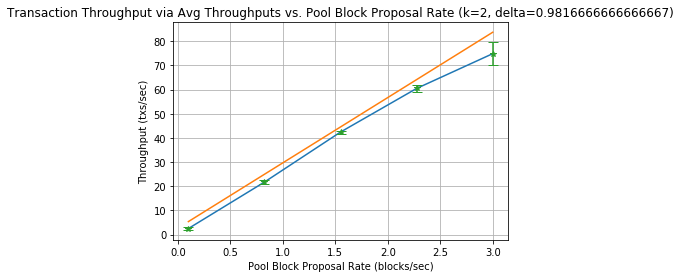

In [5]:
import matplotlib.pylab as plt


def plot_results(title, xlabel, ylabel, x, y, std_dev, y_exp):
    sd = np.array(list(std_dev.values()))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    
    plt.plot(x, y, label='observed rate')
    plt.plot(x, y_exp, label='expected rate')
    plt.errorbar(x, y, sd, capsize=5, linestyle='None', marker='*')
    plt.show()

print(avg_throughputs, exp_throughput)
plot_results(
f'Transaction Throughput via Avg Throughputs vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Throughput (txs/sec)',
x,
avg_throughputs,
throughput_sd,
exp_throughput
)

Note how the expected throughput is slightly greater than the computed throughput. This descrepancy is caused by the finalization depth of blocks. The expected throughput is computed based on a main chain where **all** blocks on the main chain are finalized, but this is not the case in a temporary simulation. Hence, the computed throughput is slightly lower.

In [6]:
'''
plot_results(
f'Unique Transaction Throughput via Avg Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Unique Throughput (txs/sec)',
x,
avg_uniq_throughputs,
uniq_throughput_sd,
exp_uniq_throughput_avg_throughput
)

plot_results(
f'Unique Transaction Throughput via Expected Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Unique Throughput (txs/sec)',
x,
avg_uniq_throughputs,
uniq_throughput_sd,
exp_uniq_throughput_exp_throughput
)
'''

"\nplot_results(\nf'Unique Transaction Throughput via Avg Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Unique Throughput (txs/sec)',\nx,\navg_uniq_throughputs,\nuniq_throughput_sd,\nexp_uniq_throughput_avg_throughput\n)\n\nplot_results(\nf'Unique Transaction Throughput via Expected Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Unique Throughput (txs/sec)',\nx,\navg_uniq_throughputs,\nuniq_throughput_sd,\nexp_uniq_throughput_exp_throughput\n)\n"

In [7]:
'''
plot_results(
f'Pool Block Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Pool Block Arrival Latency (sec)',
x,
avg_pool_block_arr_lat,
pool_block_arr_sd,
exp_pool_block_arr_lat
)
'''

"\nplot_results(\nf'Pool Block Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Pool Block Arrival Latency (sec)',\nx,\navg_pool_block_arr_lat,\npool_block_arr_sd,\nexp_pool_block_arr_lat\n)\n"

In [8]:
'''
plot_results(
f'Pool Block Reference Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Pool Block Reference Latency (sec)',
x,
avg_pool_block_ref_lat,
pool_block_ref_sd,
exp_pool_block_ref_lat
)
'''

"\nplot_results(\nf'Pool Block Reference Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Pool Block Reference Latency (sec)',\nx,\navg_pool_block_ref_lat,\npool_block_ref_sd,\nexp_pool_block_ref_lat\n)\n"

In [9]:
'''
plot_results(
f'Main Chain Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Main Chain Arrival Latency (sec)',
x,
avg_mca_lat,
mca_lat_sd,
exp_mca_lat
)
'''

"\nplot_results(\nf'Main Chain Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Main Chain Arrival Latency (sec)',\nx,\navg_mca_lat,\nmca_lat_sd,\nexp_mca_lat\n)\n"

In [10]:
'''
plot_results(
f'Finalization Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Finalization Latency (sec)',
x,
avg_fin_lat,
fin_lat_sd,
exp_fin_lat
)
'''

"\nplot_results(\nf'Finalization Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Finalization Latency (sec)',\nx,\navg_fin_lat,\nfin_lat_sd,\nexp_fin_lat\n)\n"

In [11]:
'''
plot_results(
f'Emptiness vs. Pool Block Proposal Rate (k={k}, delta={delta})',
'Pool Block Proposal Rate (blocks/sec)',
'Emptiness (txs)',
x,
avg_emp,
emp_sd,
exp_emp
)
'''

"\nplot_results(\nf'Emptiness vs. Pool Block Proposal Rate (k={k}, delta={delta})',\n'Pool Block Proposal Rate (blocks/sec)',\n'Emptiness (txs)',\nx,\navg_emp,\nemp_sd,\nexp_emp\n)\n"

### Results

We can look through the logs of the blocks to understand the process a block undergoes:

In [12]:
with open('../logs/blocks.csv') as f:
    for line in f.readlines()[:10]:
        print(line)

id,parent id,proposal timestamp,pool block timestamp,finalization timestamp,depth,finalized,emptiness,pool blocks,transactions

Genesis,None,0,None,38.6978947369803,0,True,0,,

f446d,Genesis,16.398076263355854,None,40.54261717726019,1,True,-1,3bdc7;dae2e;12139;fce2d;c6cb4;eb28c;250c3;31b4b;55a8c;11dde;c0bcf;b2780;fecef;5578d;c49e3;1e5f1;9b7b0;0cda0;bbd89;39551;f7051;b2ab4;93fff;cbe05;b0d0f;8e9e6;3f079;31ee1;eef36;21c31;50ed6;e042b;972b8;3f4c5;81cb1;b2324;72833;69ec7;b02f8;51216;f40c2;207ee;10ee2,037e6aa1a0;c051746561;3a5f08f16b;20eee4a256;d3e8bbb30f;18c11c3f19;dae77dfb4f;5bb1af750a;abdcc3639b;a9562cd209;3ac8752243;4063fdf0a6;8460370d4f;d6d07ee9b2;34edc1b0eb;7a9c5a1ecd;aa82d5bd1a;d02c57126f;1e0c6991c9;c3a9c10fa6;2076c9fe6b;9985af7f64;5af23ea61f;bcb8784d12;08784abbcd;2fc9567fff;afd0fa9fb5;2ca92272ce;561a885d85;8452a1864f;799bc8e40b

3bdc7,None,0.7824936685985426,,40.54261717726019,NA,True,11,NA,d3da6d33d4;c764cb03c9;6822e47b9f;037e6aa1a0;0c509305ea;b40746c309;f864f4f6d8;08dfe4723c;479082

Additionally, we can visualize the results to see the global blocktree. In the following image, blue nodes indicate tree blocks on the main chain and yellow blocks indicate tree blocks
off the main chain (i.e. 'orphan blocks').
![title](../logs/blocktree.png)

We can look through the logs to understand the process a transaction undergoes. A transaction can

1) Be a pool or a tree transaction
2) Be on the main chain or not on the main chain
3) Be finalized or not finalized

Hence, we will analyze each of the following cases:
1) A pool transaction on the main chain that is finalized
2) A pool transaction not on the main chain
3) A tree transaction on the main chain that is finalized
4) A tree transaction on the main chain that is not finalized
5) A tree transaction not on the main chain

In [13]:
import csv

finalized_main_chain_pool_tx = None
not_on_main_chain_pool_tx = None
finalized_main_chain_tree_tx = None
unfinalized_main_chain_tree_tx = None
not_on_main_chain_tree_tx = None

with open('../logs/transactions.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    row_count = 0
    for row in reader:
        if row['finalization timestamps']!='None'and row['main chain arrival timestamp']!='None' and row['pool block reference timestamp']!='None' and finalized_main_chain_pool_tx==None:
            finalized_main_chain_pool_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block reference timestamp']!='None' and not_on_main_chain_pool_tx==None:
            not_on_main_chain_pool_tx = row
        elif row['finalization timestamps']!='None' and row['main chain arrival timestamp']!='None' and row['pool block reference timestamp']=='None' and finalized_main_chain_tree_tx==None:
            finalized_main_chain_tree_tx = row
        elif row['finalization timestamps']=='None' and row['main chain arrival timestamp']!='None' and row['pool block reference timestamp']=='None' and unfinalized_main_chain_tree_tx==None:
            unfinalized_main_chain_tree_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block reference timestamp']=='None' and not_on_main_chain_tree_tx==None: 
            not_on_main_chain_tree_tx = row
        if row_count<10:
            print(row)
        row_count+=1

OrderedDict([('id', '6822e47b9f'), ('source node', '7'), ('generated timestamp', '0.030064122456812153'), ('pool block arrival timestamp', '16.803871507529074'), ('pool block reference timestamp', '38.6978947369803'), ('main chain arrival timestamp', '38.6978947369803'), ('finalization timestamps', '40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;52.26913539557582;52.26913539557582')])
OrderedDict([('id', '037e6aa1a0'), ('source node', '0'), ('generated timestamp', '0.05689360620168051

In [14]:
print(f'Finalized Pool Transaction:\n{finalized_main_chain_pool_tx}')
print(f'Pool Transaction Not on Main Chain:\n{not_on_main_chain_pool_tx}')
print(f'Finalized Tree Transaction:\n{finalized_main_chain_tree_tx}')
print(f'Unfinalized Tree Transaction:\n{unfinalized_main_chain_tree_tx}')
print(f'Tree Transaction Not on Main Chain:\n{not_on_main_chain_tree_tx}')


Finalized Pool Transaction:
OrderedDict([('id', '6822e47b9f'), ('source node', '7'), ('generated timestamp', '0.030064122456812153'), ('pool block arrival timestamp', '16.803871507529074'), ('pool block reference timestamp', '38.6978947369803'), ('main chain arrival timestamp', '38.6978947369803'), ('finalization timestamps', '40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;40.54261717726019;52.26913539557582;52.26913539557582')])
Pool Transaction Not on Main Chain:
OrderedDict([('id', '2d65a4b2e4'), ('

Let's consider the first case of the finalized pool transaction. If we look into `blocks.csv`,
we should be able to see that the transaction's main chain arrival timestamp and pool block timestamp
should be equivalent to a tree block's proposal time. Additionally, the finalization time should be
the tree block's finalization time.

In [15]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_pool_tx!=None:
        for row in reader:
            if finalized_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '3bdc7'), ('parent id', 'None'), ('proposal timestamp', '0.7824936685985426'), ('pool block timestamp', ''), ('finalization timestamp', '40.54261717726019'), ('depth', 'NA'), ('finalized', 'True'), ('emptiness', '11'), ('pool blocks', 'NA'), ('transactions', 'd3da6d33d4;c764cb03c9;6822e47b9f;037e6aa1a0;0c509305ea;b40746c309;f864f4f6d8;08dfe4723c;4790827036;122bfa26fe;0d3a434fa5;c051746561;4508693f79;d0b33c7c48;bfa818d03f;3a5f08f16b;c0d89b2cb1;7e2991dc21;8c9d5e4b20')])


Now let's consider the second case of the pool transaction not on the main chain.
We should see that it belongs to a block that is not finalized and not on the main chain, indicated
by the fact the block's finalization timestamp and main chain arrival timestamp will both be `'None'`. However, the pool block timestamp should be equal to the block's proposal timestamp.

In [16]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if not_on_main_chain_pool_tx!=None:
        for row in reader:
            if not_on_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '500e5'), ('parent id', '3fbd7'), ('proposal timestamp', '387.9258914785497'), ('pool block timestamp', 'None'), ('finalization timestamp', 'None'), ('depth', '32'), ('finalized', 'False'), ('emptiness', '-1'), ('pool blocks', '7defe;e08da;400e2'), ('transactions', '2d65a4b2e4;6af784d6a0;d0053975b9;1fdba2e3a8;7a610e0536;c7faf85c43;99a7dd1e03;9a6ac00b46;f0f0d67e5b;3513f79e9d;8ffcc41114;0f45d16830;b60da1feb7;312bcf2c8a;ca65cd9355;87a967cf59;b32e7af458;5579905e9c;a4a972e01c;60a48b955b;c40b86e3af;4f59cfc6a2;526c7a929c;d71df97048;19b268323f;79d75afba6;6a4da1449f;45d7c3106d;1f33e08509;72b43e2be0;c47960c9f9')])


The third case is the tree finalized tree transaction on the main chain. We should see that it
belongs to a block with equal finalization and main chain arrival timestamps, but a pool block timestamp equal to `'None'`.

In [17]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_tree_tx!=None:
        for row in reader:
            if finalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '1126b'), ('parent id', 'd8861'), ('proposal timestamp', '40.54261717726019'), ('pool block timestamp', 'None'), ('finalization timestamp', '56.5176592454012'), ('depth', '3'), ('finalized', 'True'), ('emptiness', '-1'), ('pool blocks', 'ce9a0;00383'), ('transactions', '48496baf7d;4434f6793a;d8c771e1a9;8e987fc226;ec11b732e3;0d75627ab8;9b78cf1752;0a34d62c0b;a5eb64cdd4;e5d551d42b;f01e20d653;29276b75e6;90e142cfaa;7252de8ff5;f5ed8a5367;6b07855a3c;4ed3fa443c;f115f79ec3;431549d0bf;8317832aa0;f1db8ede67;2b35fa9344;292fc47d24;9ad24da093;6cba30bf34;5773d89c48;dd9dcc0993;686f1398bc;0d48f02262;9afe23ec45;8c89bb6b4b')])


The fourth case is the unfinalized tree transaction on the main chain. We should see that it
belongs to a block with equal main chain arrival timestamp, but pool block and finalization
timestamps equal to `'None'`.

In [18]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if unfinalized_main_chain_tree_tx!=None:
        for row in reader:
            if unfinalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

The final case is the tree transaction not on the main chain. The block is not used for any statistics and is not logged.